In [18]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install Keras-Preprocessing
%pip install tensorflow
%pip install keras
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import torch

In [66]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [21]:
# categories_names = os.listdir("train/")
# filenames = []
# categories = []
# for category in categories_names:
#     files = os.listdir("train/"+category+"/")
#     filenames.extend(files)
#     categories += [category] * len(files)


In [22]:
filenames = os.listdir("training_v/")
categories = []
category_names = []
for filename in filenames:
    category = filename.split('_')[0]
    categories.append(category)
    if(category not in category_names): category_names.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(category_names)

['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [6]:
df.head()

filename      category
0  agricultural_000001.png  agricultural
1  agricultural_000003.png  agricultural
2  agricultural_000005.png  agricultural
3  agricultural_000006.png  agricultural
4  agricultural_000008.png  agricultural

In [7]:
df.tail()

filename     category
7345  tenniscourt_000492.png  tenniscourt
7346  tenniscourt_000493.png  tenniscourt
7347  tenniscourt_000496.png  tenniscourt
7348  tenniscourt_000497.png  tenniscourt
7349  tenniscourt_000498.png  tenniscourt

<Axes: xlabel='category'>

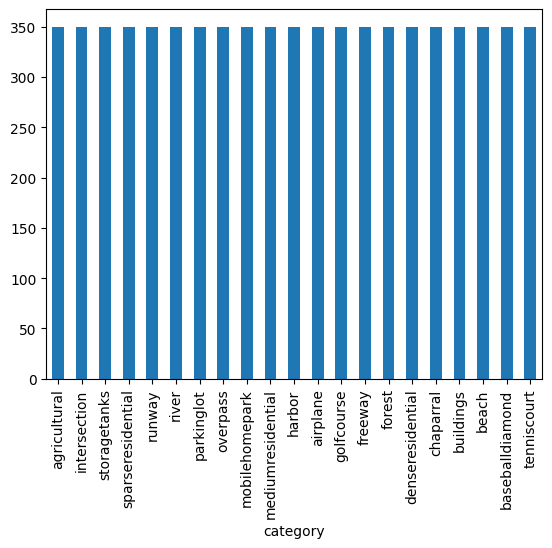

In [8]:
df['category'].value_counts().plot.bar()

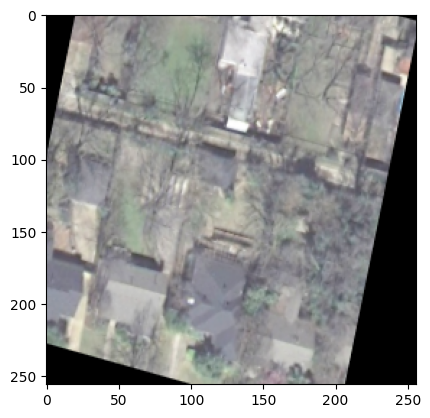

In [9]:
sample = random.choice(filenames)
image = load_img("training_v/"+sample)
plt.imshow(image)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
import time
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# First hidden Layer 
# Convolution layers are used to detect patterns such as edges, textures, and shapes in images
#32 will be number of filters, 3*3 will be size of matrix that used detect edges such as vertical etc
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
# Pooling reduces the size of the dimensions of the image with max value
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Second hidden Layer

#64 number of filters, 3*3  will be size of matrix that used detect edges such as face etc
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Third hidden Layer
#128 number of filters, 3*3  will be size of matrix that used detect edges such as face etc
#filters doubles on every layer to have more complex pattern found on pass of each layer
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Dense layer with 512 units has a high capacity to learn complex patterns and representations.
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
# output layer
model.add(Dense(len(category_names), activation='softmax'))

# optimizer adjusts the learning rate during training
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
earlystop = EarlyStopping(patience=10)

In [10]:
# reduce learning rate when accuracy is not improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

In [69]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

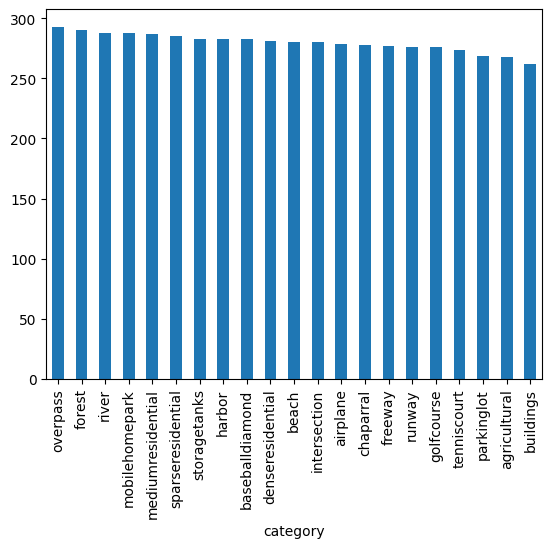

In [70]:
train_df['category'].value_counts().plot.bar()
# validate_df['category'].value_counts().plot.bar()

In [71]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

print(total_train)
print(total_validate)

5880
1470


In [72]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "training_v/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5880 validated image filenames belonging to 21 classes.


In [17]:
print(train_df['category'])
print(validate_df['category'].dtype)


0            storagetanks
1            agricultural
2                overpass
3       mediumresidential
4                airplane
              ...        
5875             overpass
5876             overpass
5877           parkinglot
5878      baseballdiamond
5879          tenniscourt
Name: category, Length: 5880, dtype: object
object


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "training_v/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1470 validated image filenames belonging to 21 classes.


Found 1 validated image filenames belonging to 1 classes.


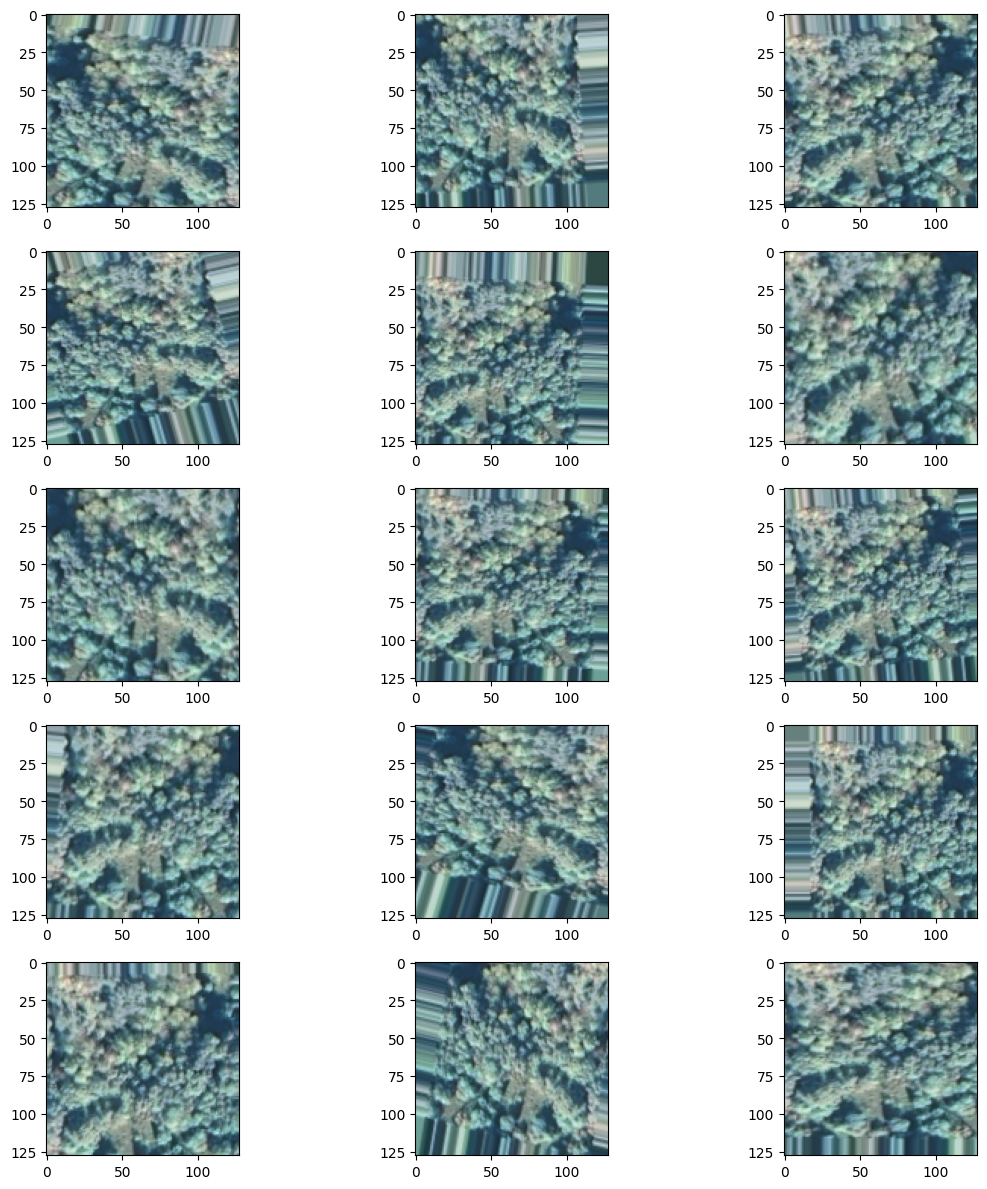

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "training_v/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [20]:
# epochs=3 if FAST_RUN else 5
epochs= 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
183/183 [==============================] - 95s 508ms/step - loss: 2.9529 - accuracy: 0.2440 - val_loss: 6.7340 - val_accuracy: 0.0674 - lr: 0.0010
Epoch 2/50
183/183 [==============================] - 92s 502ms/step - loss: 2.1646 - accuracy: 0.3794 - val_loss: 8.3895 - val_accuracy: 0.0861 - lr: 0.0010
Epoch 3/50
183/183 [==============================] - 93s 505ms/step - loss: 1.7840 - accuracy: 0.4637 - val_loss: 4.7087 - val_accuracy: 0.2007 - lr: 0.0010
Epoch 4/50
183/183 [==============================] - 92s 502ms/step - loss: 1.5150 - accuracy: 0.5222 - val_loss: 2.4382 - val_accuracy: 0.3639 - lr: 0.0010
Epoch 5/50
183/183 [==============================] - 92s 504ms/step - loss: 1.3279 - accuracy: 0.5811 - val_loss: 6.5905 - val_accuracy: 0.2958 - lr: 0.0010
Epoch 6/50
183/183 [==============================] - 92s 504ms/step - loss: 1.1681 - accuracy: 0.6324 - val_loss: 1.4778 - val_accuracy: 0.5757 - lr: 0.0010
Epoch 7/50
183/183 [==============================] 

In [22]:
import os
 
import tensorflow as tf
from tensorflow import keras
model.save(f"savedModel/tensor_v1.h5")

In [ ]:
model.save_weights("hackathon.weights.h5")

In [ ]:
history.history.keys()

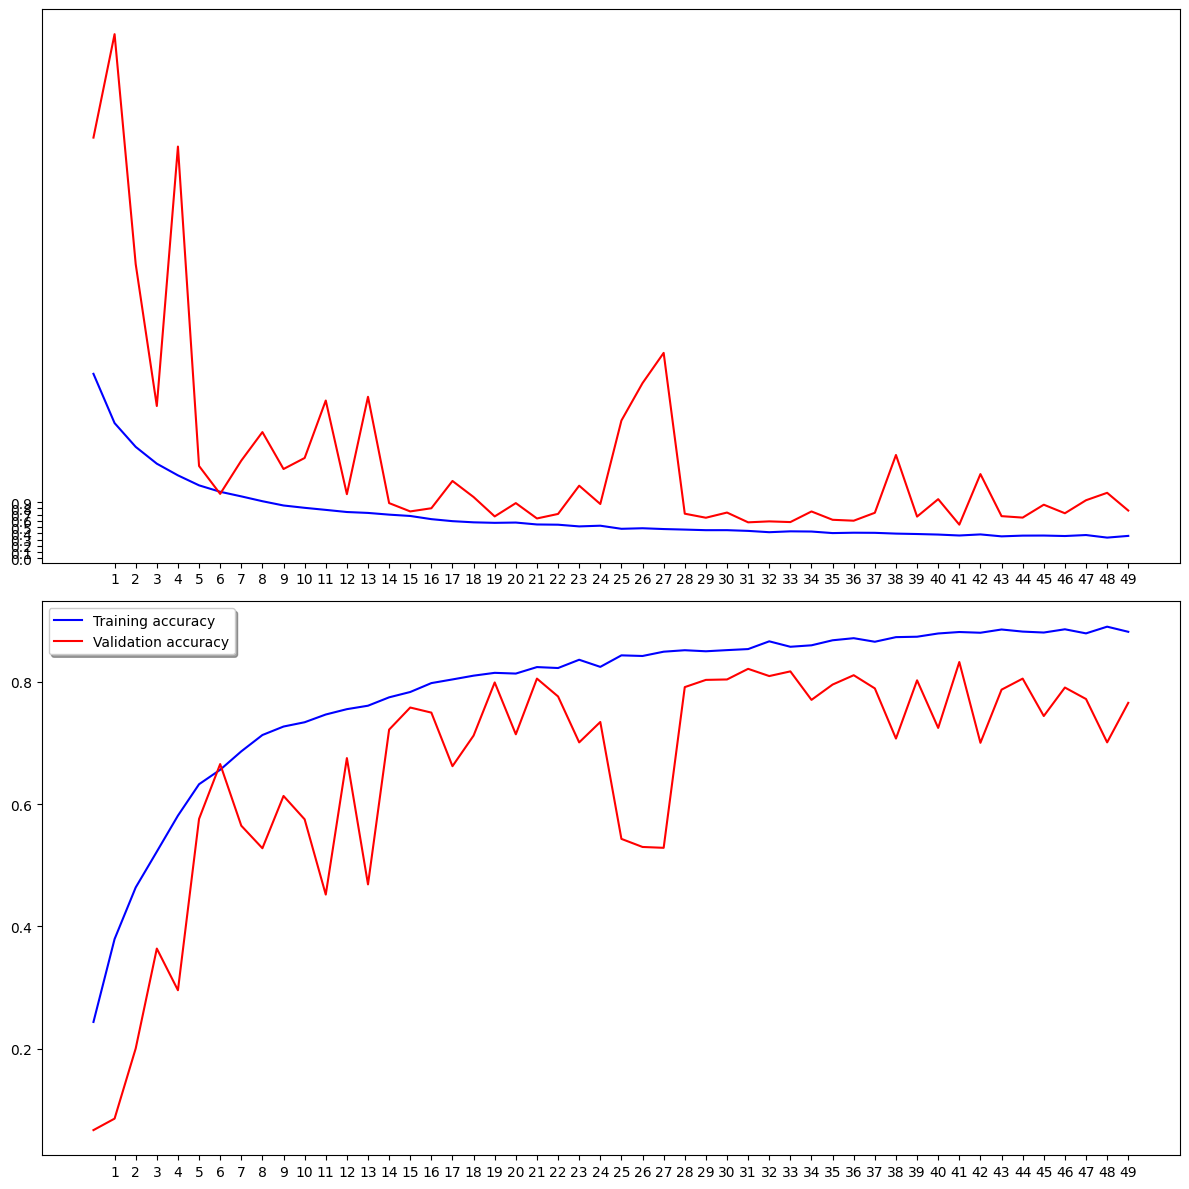

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [63]:
test_filenames = os.listdir("test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]


In [64]:
# test_df.head()
nb_samples
print(nb_samples)

1050


In [73]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1050 validated image filenames.


In [85]:
test_loss , test_acc = model.evaluate(test_generator,steps=int(1050 /32))

32/32 [==============================] - 3s 86ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [84]:
print(test_acc)

0.0


In [30]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'].value_counts()

category
beach                85
river                75
sparseresidential    73
storagetanks         73
denseresidential     69
freeway              61
mobilehomepark       56
intersection         54
agricultural         53
forest               51
harbor               49
chaparral            47
runway               44
overpass             43
parkinglot           43
tenniscourt          38
golfcourse           33
mediumresidential    33
buildings            30
baseballdiamond      27
airplane             13
Name: count, dtype: int64

<Axes: xlabel='category'>

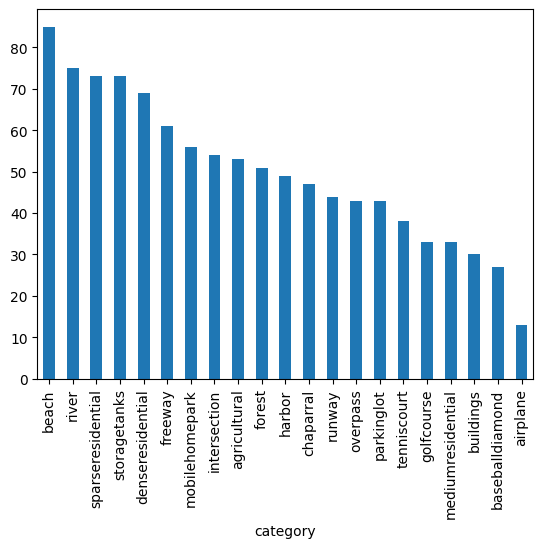

In [31]:
test_df['category'].value_counts().plot.bar()   

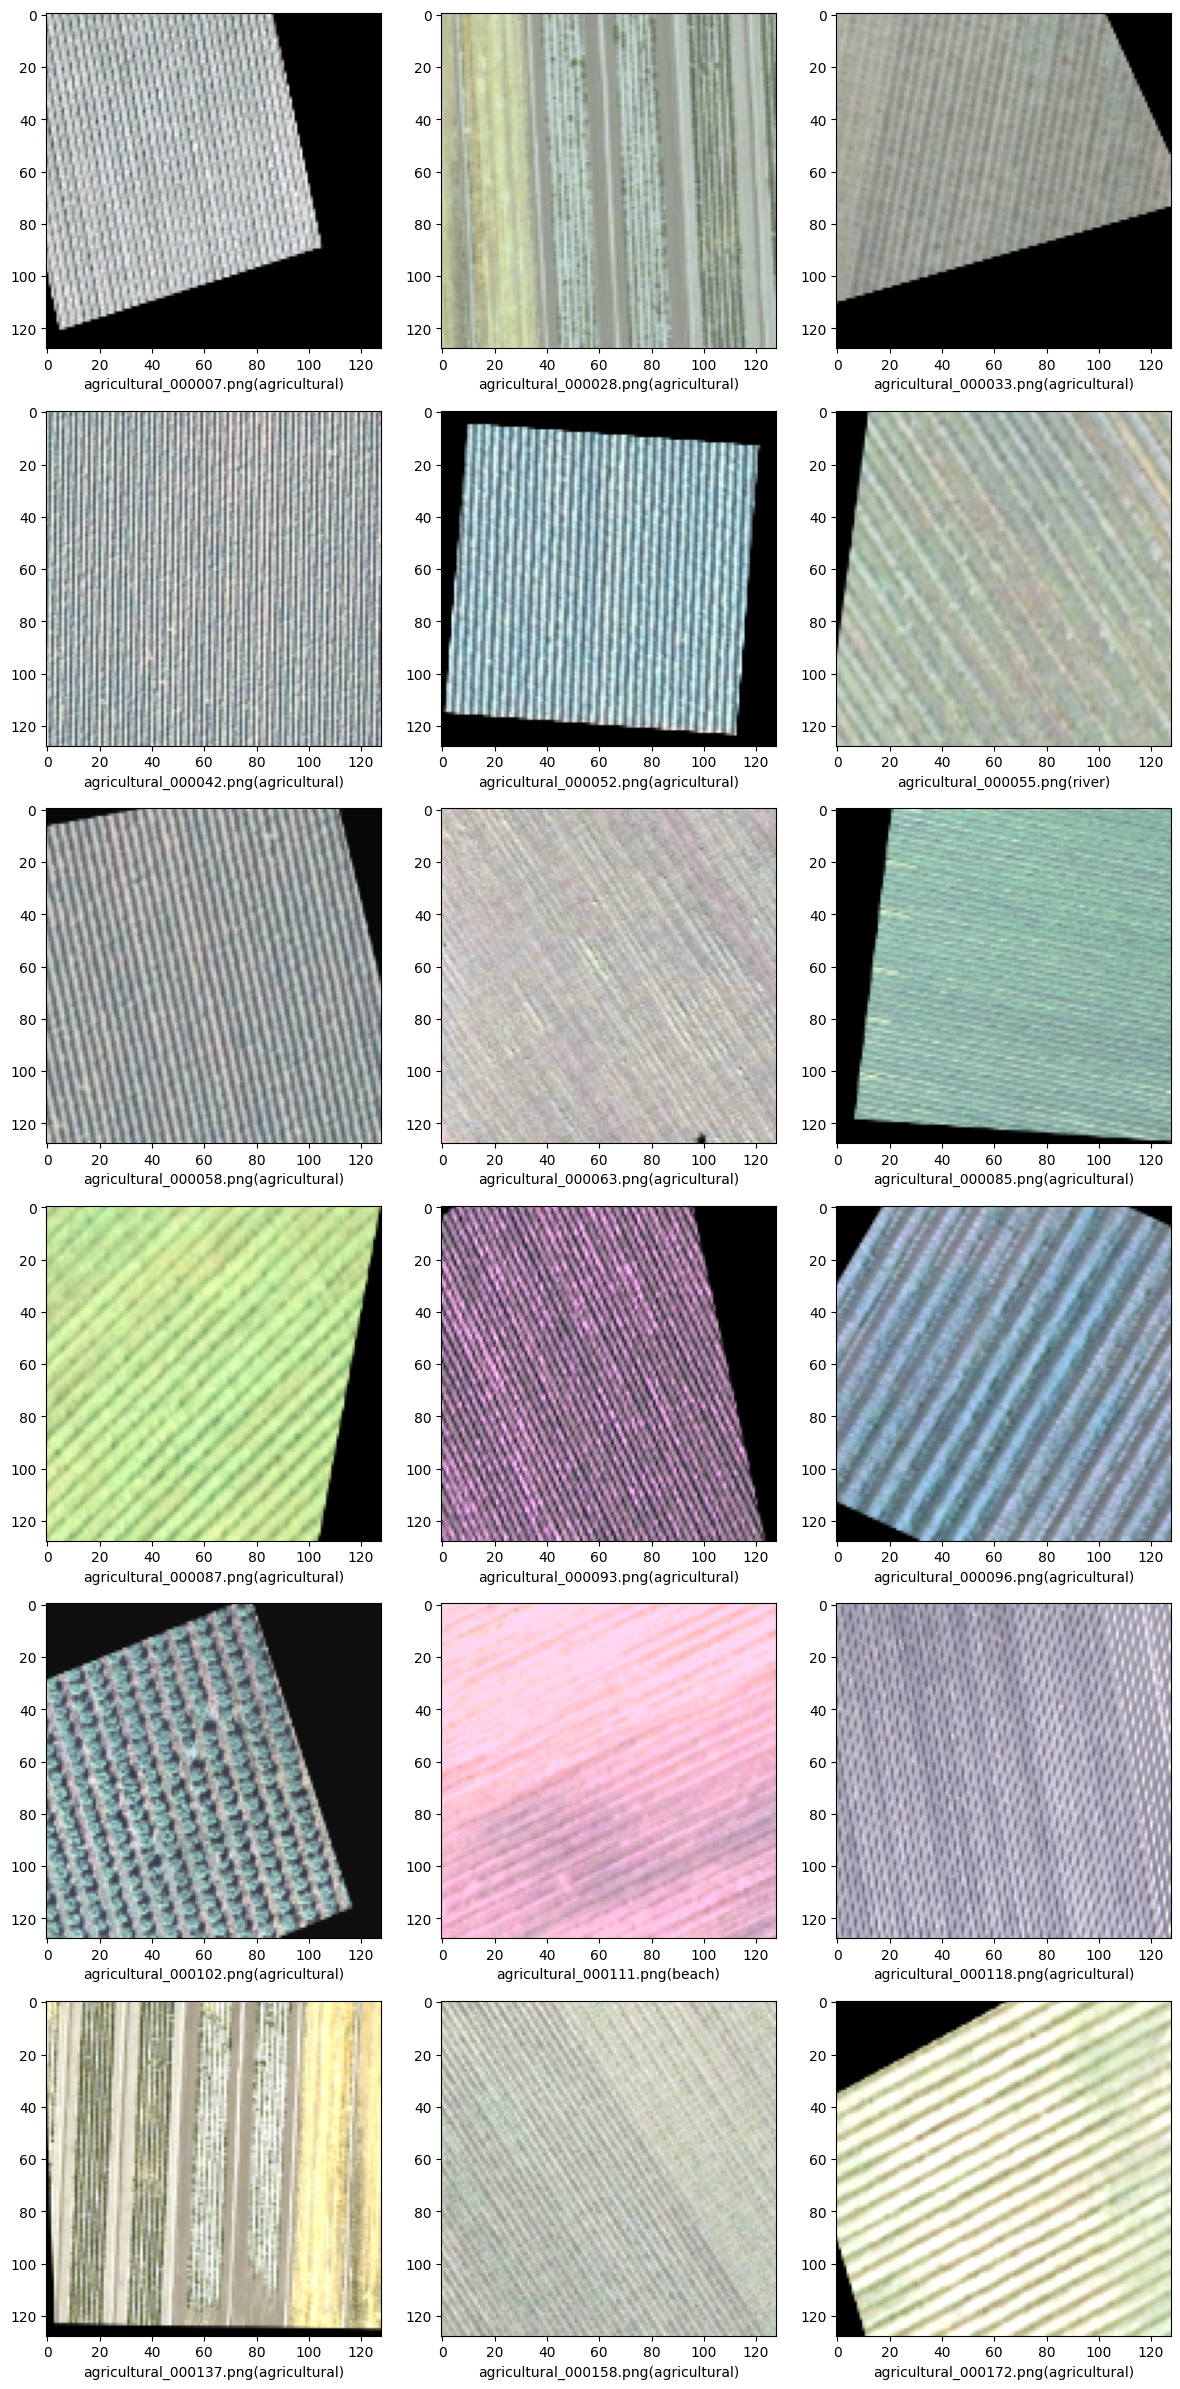

In [39]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [40]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('fruit_submission.csv', index=False)

In [ ]:
# %pip install seaborn

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

In [4]:
from keras.preprocessing import image
def load_and_preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Rescale the image
    img_array = img_array / 255.0
    # Expand dimensions to match the input shape (1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [13]:
# Path to the single image you want to predict
img_path = 'Dataset/test/test2.jpg'
mo = model = load_model('savedModel/tensor_v1.h5')
# Load and preprocess the image
img_array = load_and_preprocess_image(img_path, target_size=IMAGE_SIZE)

# Make a prediction
prediction = model.predict(img_array)

# Convert prediction to class label
predicted_class = np.argmax(prediction, axis=1)

# # Assuming you have a dictionary to map class indices to class names
# class_indices = {0: 'class_name_0', 1: 'class_name_1', ..., 14: 'class_name_14'}  # Modify this as per your classes
# predicted_label = class_indices[predicted_class[0]]

# print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 196ms/step


In [23]:
predict_labels = (prediction > 0.5).astype(int)
print(predict_labels)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [24]:
print(predicted_class[0])
predicted_probability = prediction[0][predicted_class[0]]
print(predicted_probability)

11
0.2695035


In [89]:
predicted_variables= []
for index in range(len(category_names)):
    # Convert np.float64 to native Python float
    prediction_value = float(prediction[0][index])
    print(prediction_value)

    # Check condition
    # if round(prediction_value) > 0.2:
    #     predicted_variables.append(category_names[index])
    # print(index, category_names[index], prediction[0][index])

print(predicted_variables)

0.0017394406022503972
9.232933371094987e-05
0.024143846705555916
0.04226887226104736
0.007464510854333639
0.00012545315257739276
0.06161273643374443
0.002601807238534093
0.009777712635695934
0.011796961538493633
0.000409440603107214
0.26950350403785706
0.051660601049661636
0.0004941328661516309
0.002017596736550331
2.1526337150135078e-05
0.12143779546022415
0.004141759127378464
0.13882645964622498
0.034558020532131195
0.21530547738075256
[]


[11]


In [26]:
category_names[predicted_class[0]]

'intersection'